In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

from pycircstat2 import Circular, load_data

# Circular Statistics in R (Pewsey, et al., 2014)

## Chapter 2

### Figure 2.1 Linear plot v.s. Circular plot

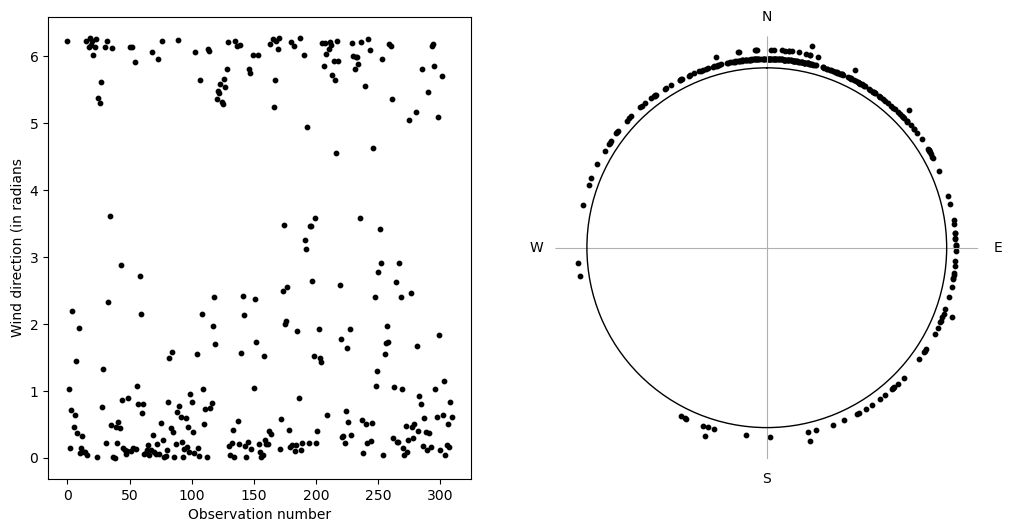

In [2]:
d21 = load_data('wind', source='pewsey')['x'].values
c21 = Circular(data=d21, unit='radian')

fig = plt.figure(figsize=(12, 6))
ax_linear = fig.add_subplot(121)

ax_linear.scatter(np.arange(len(d21)), d21, s=10, color='black')
ax_linear.set_xlabel('Observation number')
ax_linear.set_ylabel('Wind direction (in radians')

ax_circular = fig.add_subplot(122, polar=True)
c21.plot(
    ax=ax_circular,
    plot_rose=False,
    plot_density=False,
    plot_mean=False,
    plot_median=False,
    r_max_scatter=1,
    marker_color='black'
)

from matplotlib import ticker

position_major = np.arange(0, 2 * np.pi, 2 * np.pi / 4)
labels = ['N', 'E', 'S', 'W']
ax_circular.xaxis.set_major_locator(ticker.FixedLocator(position_major))
ax_circular.xaxis.set_major_formatter(ticker.FixedFormatter(labels))


### Figure 2.2

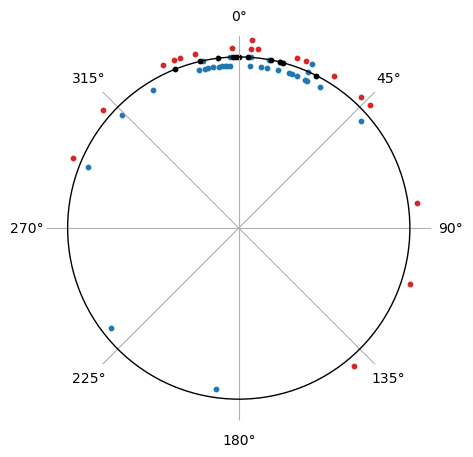

In [3]:
d22 = load_data('B10', source='fisher')

c22s1 = Circular(data=d22[d22['set'] == 1]['θ'], unit='degree')
c22s2 = Circular(data=d22[d22['set'] == 2]['θ'], unit='degree')
c22s3 = Circular(data=d22[d22['set'] == 3]['θ'], unit='degree')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(polar=True)


c22s2.plot(
    ax=ax,
    plot_rose=False,
    plot_density=False,
    plot_mean=False,
    plot_median=False,
    r_max_scatter=.9,
    marker_color='C0'
)


c22s1.plot(
    ax=ax,
    plot_rose=False,
    plot_density=False,
    plot_mean=False,
    plot_median=False,
    r_max_scatter=0.95,
    marker_color='black'
)



c22s3.plot(
    ax=ax,
    plot_rose=False,
    plot_density=False,
    plot_mean=False,
    plot_median=False,
    r_max_scatter=1.,
    marker_color='C3'
)


### Figure 2.3 Circular plot with rose diagram

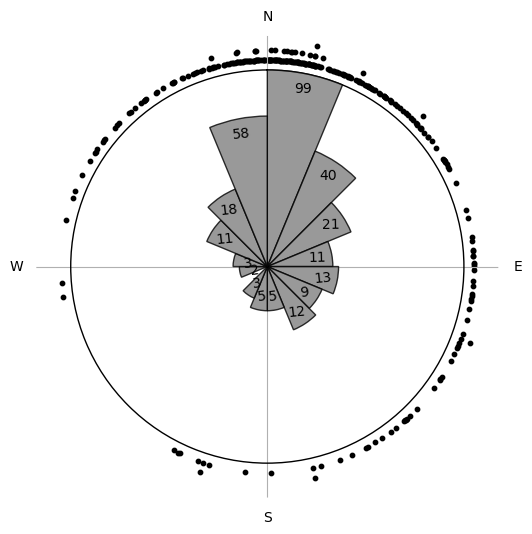

In [4]:
fig = plt.figure(figsize=(12, 6))
ax= fig.add_subplot(polar=True)

c21.plot(
    ax=ax,
    figsize=(4,4),
    plot_rose=True,
    bins=16,
    plot_density=False,
    plot_mean=False,
    plot_median=False,
    r_max_scatter=1,
    marker_color='black',
    plot_counts=True,
)

from matplotlib import ticker

position_major = np.arange(0, 2 * np.pi, 2 * np.pi / 4)
labels = ['N', 'E', 'S', 'W']
ax.xaxis.set_major_locator(ticker.FixedLocator(position_major))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))


### Figure 2.4 Circular plot with rose diagrams and three kernel density estimates

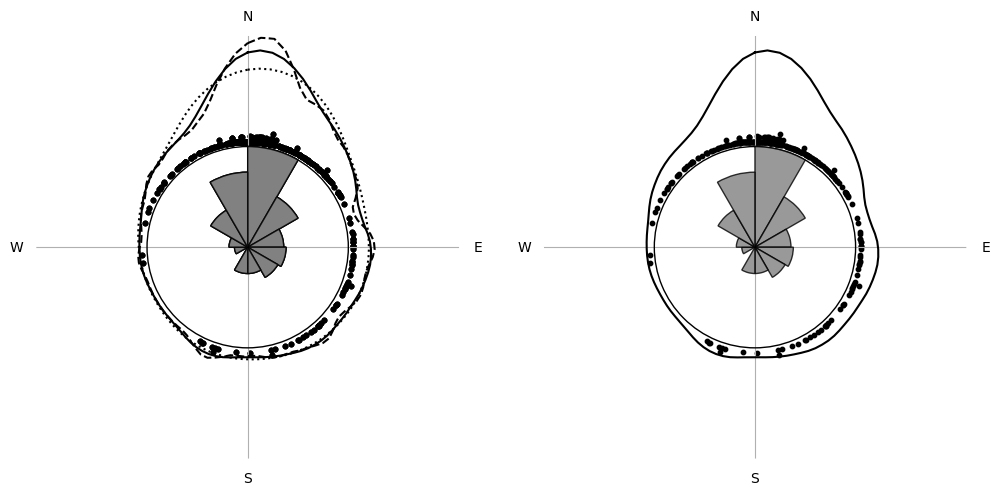

In [5]:
d21 = load_data('wind', source='pewsey')['x'].values
c21 = Circular(data=d21, unit='radian')

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121, polar=True)

h0s = [0.2, 0.4, 0.75]
lss = ['dashed', 'solid', 'dotted']

for h0, ls in zip(h0s, lss):

    c21.plot(
        ax=ax0,
        plot_rose=True,
        plot_density=True,
        kwargs_density={
            'method': 'nonparametric',
            'h0': h0,
            "color": 'black',
            'linestyle':ls,
            },
        plot_mean=False,
        plot_median=False,
        r_max_scatter=1,
        marker_color='black',
        rlim_max=2.1
    )

ax1 = fig.add_subplot(122, polar=True)
c21.plot(
    ax=ax1,
    plot_rose=True,
    plot_density=True,
    kwargs_density={
        'method': 'nonparametric',
        'h0': 0.4,
        "color": 'black',
        'linestyle':'solid',
        },
    plot_mean=False,
    plot_median=False,
    r_max_scatter=1,
    marker_color='black',
    rlim_max=2.1
)

from matplotlib import ticker

position_major = np.arange(0, 2 * np.pi, 2 * np.pi / 4)
labels = ['N', 'E', 'S', 'W']

for ax in [ax0, ax1]:
    ax.xaxis.set_major_locator(ticker.FixedLocator(position_major))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))


## Chapter 4 Circular Models

In [15]:
from scipy.special import gamma
from scipy.stats import rv_continuous

class cardioid_gen(rv_continuous):

    def _argcheck(self, rho):
        return 0 < rho <= 1/2

    def _pdf(self, x, rho):
        return (1 + 2 * rho * np.cos(x)) / 2. / np.pi

    def _cdf(self, x, rho):
        return rho * np.sin(x) + x / (2 * np.pi)

class cartwright_gen(rv_continuous):

    def _argcheck(self, zeta):
        return zeta > 0

    def _pdf(self, x, zeta):
        return (2 ** (-1 + 1 / zeta) * (gamma(1 + 1 / zeta))**2) * (1 + np.cos(x)) ** ( 1/zeta ) / (np.pi * gamma(1 + 2 / zeta)) 

class wrapnorm_gen(rv_continuous):

    def _argcheck(self, rho):
        return 0 < rho <= 1

    def _pdf(self, x, rho):
        return (1 + 2 * np.sum([rho ** (p ** 2) * np.cos(p * x) for p in range(1, 4)], 0)) / ( 2 * np.pi)

# scipy.stats.wrapcauchy seems broken
class wrapcauchy_gen(rv_continuous):

    def _argcheck(self, rho):
        return 0 < rho <= 1
   
    def _pdf(self, x, rho):
        return (1 - rho**2) / (2 * np.pi * (1 + rho**2 - 2 * rho * np.cos(x)))

    def _cdf(self, x, rho):
        num = (1 + rho ** 2) * np.cos(x) - 2 * rho
        den = 1 + rho ** 2 - 2 * rho * np.cos(x)
        return np.arccos(num / den)


cardioid = cardioid_gen()
cargwright = cartwright_gen()
wrapnorm = wrapnorm_gen()
wrapcauchy = wrapcauchy_gen()


### Figure 4.1

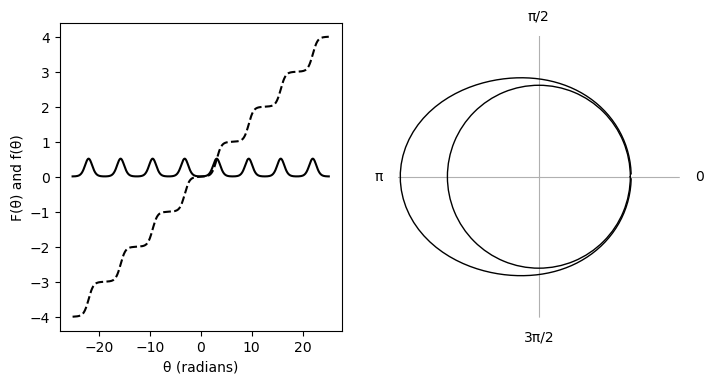

In [16]:
from scipy.stats import vonmises

mu = np.deg2rad(180)
kappa = 2
x = np.linspace(-8 * np.pi, 8 * np.pi, 800)
f = vonmises.pdf(x, kappa, loc=mu)
F = vonmises.cdf(x, kappa, loc=mu)

fig = plt.figure(figsize=(8,4))
ax0 = fig.add_subplot(121)
ax0.plot(x, f, color='black')
ax0.plot(x, F, color='black', linestyle='--')
ax0.set_xlabel('θ (radians)')
ax0.set_ylabel('F(θ) and f(θ)')

ax1 = fig.add_subplot(122, polar=True)
ax1.plot(x[400:500], f[400:500] + 1, color='black',
    linestyle='-', lw=1, label='vonmises pdf')
rtick = [0, 1]
ax1.spines["polar"].set_visible(False)
ax1.set_rgrids(rtick, ["" for _ in range(len(rtick))], fontsize=16)
gridlines = ax1.yaxis.get_gridlines()
gridlines[-1].set_color("k")
gridlines[-1].set_linewidth(1)

position_major = np.arange(0, 2 * np.pi, 2 * np.pi / 4)
ax1.xaxis.set_major_locator(ticker.FixedLocator(position_major))

labels = ['0', 'π/2', 'π', '3π/2']
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(labels))


### Figure 4.3

Text(0.5, 1.0, 'μ = π/2')

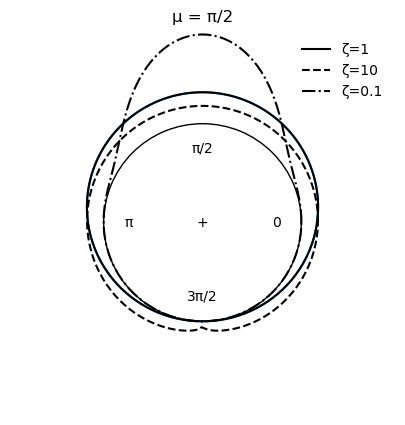

In [17]:
n = 200
x = np.linspace(0, 2 * np.pi, n)
mu = np.pi / 2

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(polar=True)

ax.plot(x, cargwright.pdf(x, zeta=1, loc=np.pi/2) + 1)

ax.plot(x, cargwright.pdf(x, zeta=1, loc=np.pi/2) + 1, linestyle='-', color='black', label='ζ=1')
ax.plot(x, cargwright.pdf(x, zeta=10, loc=np.pi/2) + 1, linestyle='--', color='black', label='ζ=10')
ax.plot(x, cargwright.pdf(x, zeta=0.1, loc=np.pi/2) + 1, linestyle='-.', color='black', label='ζ=0.1')

rtick = [0, 1]
ax.spines["polar"].set_visible(False)
ax.set_rgrids(rtick, ["" for _ in range(len(rtick))], fontsize=16)
gridlines = ax.yaxis.get_gridlines()
gridlines[-1].set_color("k")
gridlines[-1].set_linewidth(1)

# position_major = np.arange(0, 2 * np.pi, 2 * np.pi / 4)
position_major = []
ax.xaxis.set_major_locator(ticker.FixedLocator(position_major))

ax.text(x=0, y=0, s='+', ha='center', va="center", color="black",)
labels = ['0', 'π/2', 'π', '3π/2']
for i, angle in enumerate([0, np.pi/2, np.pi, 3 * np.pi / 2]):
    ax.text(x=angle, y=0.75, s=labels[i], ha='center', va="center", color="black")

ax.legend(frameon=False)
ax.set_title('μ = π/2')

### Figure 4.4

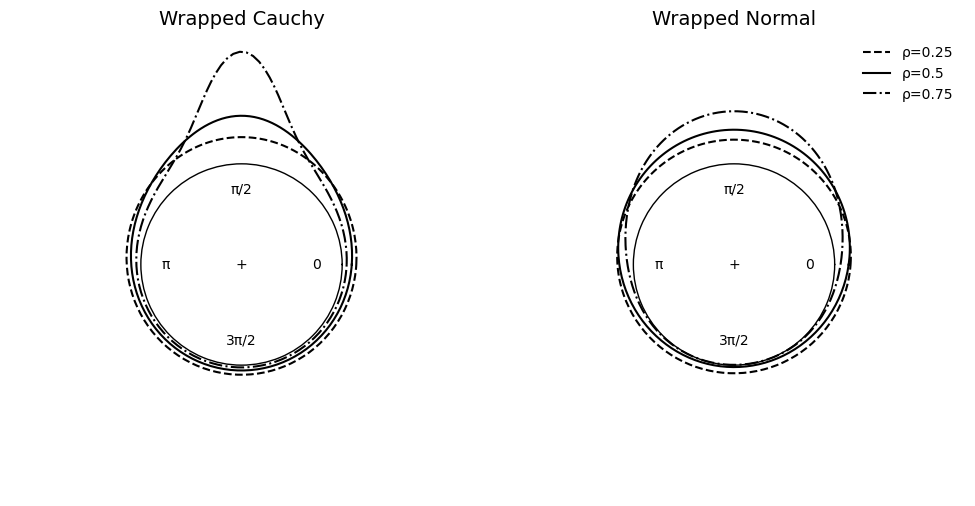

In [18]:
fig = plt.figure(figsize=(10,5))

ax0 = fig.add_subplot(121, polar=True)
ax0.plot(x, wrapcauchy.pdf(x, rho=0.25, loc=mu) + 1, linestyle='--', color='black', label='ρ=0.25')
ax0.plot(x, wrapcauchy.pdf(x, rho=0.5,  loc=mu) + 1, linestyle='-', color='black', label='ρ=0.5')
ax0.plot(x, wrapcauchy.pdf(x, rho=0.75, loc=mu) + 1, linestyle='-.', color='black', label='ρ=0.75')


ax1 = fig.add_subplot(122, polar=True)
ax1.plot(x, wrapnorm.pdf(x, rho=0.25, loc=mu) + 1, linestyle='--', color='black', label='ρ=0.25')
ax1.plot(x, wrapnorm.pdf(x, rho=0.5,  loc=mu) + 1, linestyle='-', color='black', label='ρ=0.5')
ax1.plot(x, wrapnorm.pdf(x, rho=0.75, loc=mu) + 1, linestyle='-.', color='black', label='ρ=0.75')

titles = ['Wrapped Cauchy', 'Wrapped Normal']
for j, ax in enumerate([ax0, ax1]):
    rtick = [0, 1]
    ax.spines["polar"].set_visible(False)
    ax.set_rgrids(rtick, ["" for _ in range(len(rtick))], fontsize=16)
    gridlines = ax.yaxis.get_gridlines()
    gridlines[-1].set_color("k")
    gridlines[-1].set_linewidth(1)

    # position_major = np.arange(0, 2 * np.pi, 2 * np.pi / 4)
    position_major = []
    ax.xaxis.set_major_locator(ticker.FixedLocator(position_major))

    ax.text(x=0, y=0, s='+', ha='center', va="center", color="black",)
    labels = ['0', 'π/2', 'π', '3π/2']
    for i, angle in enumerate([0, np.pi/2, np.pi, 3 * np.pi / 2]):
        ax.text(x=angle, y=0.75, s=labels[i], ha='center', va="center", color="black",)

    ax.set_ylim(0, 2.3)
    ax.set_title(f"{titles[j]}", fontsize=14)

    if j == 1:
        ax.legend(frameon=False)
fig.tight_layout()

### Figure 4.5 von Mises / cardioid / wrapped normal / wrapped Cauchy

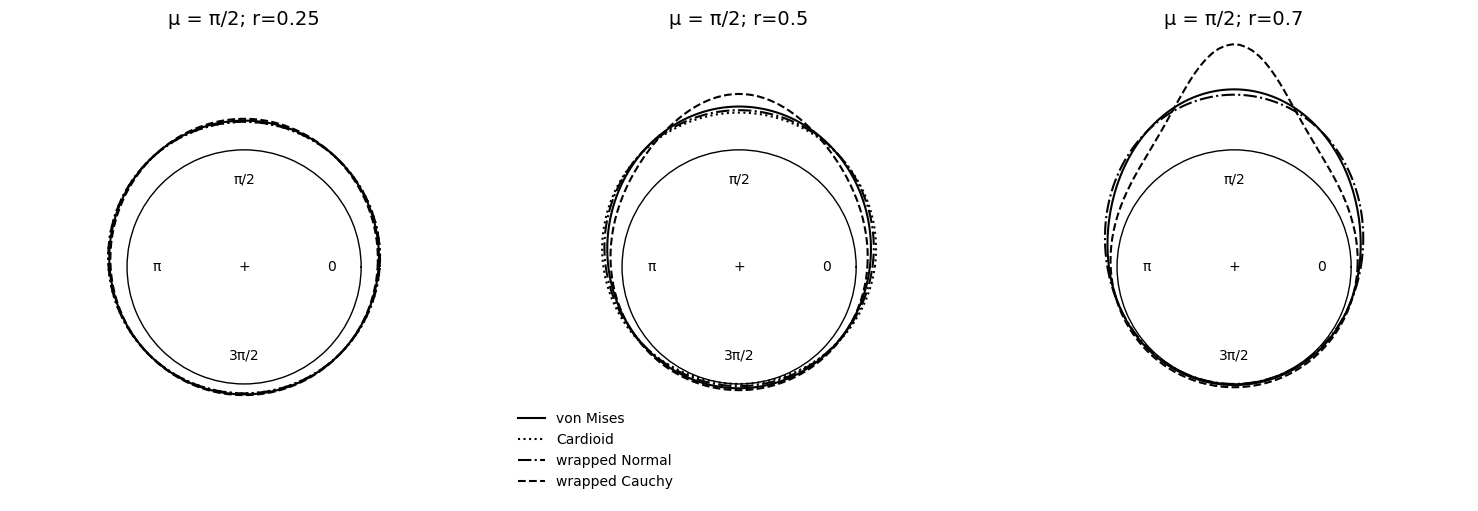

In [10]:
from pycircstat2.descriptive import circ_kappa
n = 200
x = np.linspace(0, 2 * np.pi, n)
mu = np.pi / 2

fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(131, polar=True)
r = 0.25

ax0.plot(x, vonmises.pdf(x, circ_kappa(r=r, n=n), loc=mu) + 1, linestyle='-', color='black')
ax0.plot(x, cardioid.pdf(x, rho=r, loc=mu) + 1, linestyle=':', color='black')
ax0.plot(x, wrapnorm.pdf(x, rho=r, loc=mu) + 1, linestyle='-.', color='black')
ax0.plot(x, wrapcauchy.pdf(x, rho=r, loc=mu) + 1, linestyle='--', color='black')

ax1 = fig.add_subplot(132, polar=True)
r = 0.5
ax1.plot(x, vonmises.pdf(x, circ_kappa(r=r, n=n), loc=mu) + 1, linestyle='solid', color='black', label='von Mises')
ax1.plot(x, cardioid.pdf(x, rho=r, loc=mu) + 1, linestyle=':', color='black', label='Cardioid')
ax1.plot(x, wrapnorm.pdf(x, rho=r, loc=mu) + 1, linestyle='-.', color='black', label='wrapped Normal')
ax1.plot(x, wrapcauchy.pdf(x, rho=r, loc=mu) + 1, linestyle='--', color='black',label='wrapped Cauchy')


ax2 = fig.add_subplot(133, polar=True)
r = 0.7
ax2.plot(x, vonmises.pdf(x, circ_kappa(r=r, n=n), loc=mu) + 1, linestyle='-', color='black')
ax2.plot(x, wrapnorm.pdf(x, rho=r, loc=mu) + 1, linestyle='-.', color='black', )
ax2.plot(x, wrapcauchy.pdf(x, rho=r, loc=mu) + 1, linestyle='--', color='black')

rs = [0.25, 0.5, 0.7]
for j, ax in enumerate([ax0, ax1, ax2]):
    rtick = [0, 1]
    ax.spines["polar"].set_visible(False)
    ax.set_rgrids(rtick, ["" for _ in range(len(rtick))], fontsize=16)
    gridlines = ax.yaxis.get_gridlines()
    gridlines[-1].set_color("k")
    gridlines[-1].set_linewidth(1)

    # position_major = np.arange(0, 2 * np.pi, 2 * np.pi / 4)
    position_major = []
    ax.xaxis.set_major_locator(ticker.FixedLocator(position_major))

    ax.text(x=0, y=0, s='+', ha='center', va="center", color="black",)
    labels = ['0', 'π/2', 'π', '3π/2']
    for i, angle in enumerate([0, np.pi/2, np.pi, 3 * np.pi / 2]):
        ax.text(x=angle, y=0.75, s=labels[i], ha='center', va="center", color="black",)

    ax.set_ylim(0, 2)
    ax.set_title(f"μ = π/2; r={rs[j]}", fontsize=14)

    if j == 1:
        ax.legend(frameon=False)
fig.tight_layout()

### Figure 4.6

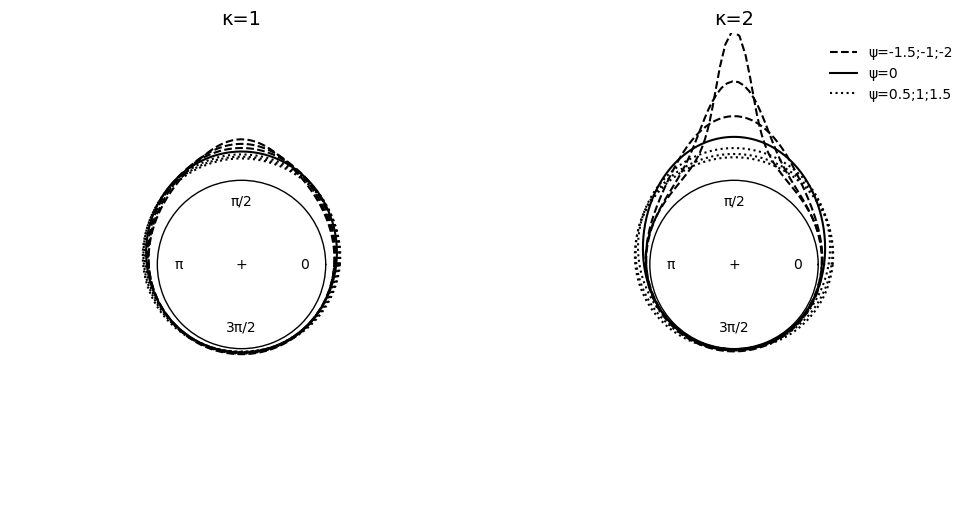

In [11]:
from scipy.integrate import quad_vec

class jonespewsey_gen(rv_continuous):   

    def _argcheck(self, kappa, psi):
        return (kappa >= 0) and (-np.inf <= psi <= np.inf)
     
    def _pdf(self, x, kappa, psi):
        def ker(x):
            return (np.cosh(kappa * psi) + np.sinh(kappa * psi) * np.cos(x)) ** (1 / psi) / (2 * np.pi * np.cosh(kappa * np.pi))
        nconst = quad_vec(ker, a=-np.pi, b=np.pi)[0]
        
        return ker(x) / nconst

jonespewsey = jonespewsey_gen(name='jonespewsey')

n = 200
x = np.linspace(0, 2 * np.pi, n)
mu = np.pi / 2

fig = plt.figure(figsize=(10,5))

ax0 = fig.add_subplot(121, polar=True)
ax0.plot(x, jonespewsey.pdf(x, kappa=1, psi=-3/2, loc=mu) + 1, linestyle='--', color='black', label='ψ=-1.5;-1;-2')
ax0.plot(x, jonespewsey.pdf(x, kappa=1, psi=-1, loc=mu) + 1, linestyle='--', color='black')
ax0.plot(x, jonespewsey.pdf(x, kappa=1, psi=-1/2, loc=mu) + 1, linestyle='--', color='black')

ax0.plot(x, jonespewsey.pdf(x, kappa=1, psi=1e-5, loc=mu) + 1, linestyle='-', color='black', label='ψ=0')

ax0.plot(x, jonespewsey.pdf(x, kappa=1, psi=1/2, loc=mu) + 1, linestyle=':', color='black', label='ψ=0.5;1;1.5')
ax0.plot(x, jonespewsey.pdf(x, kappa=1, psi=1, loc=mu) + 1, linestyle=':', color='black')
ax0.plot(x, jonespewsey.pdf(x, kappa=1, psi=3/2, loc=mu) + 1, linestyle=':', color='black')


ax1 = fig.add_subplot(122, polar=True)
ax1.plot(x, jonespewsey.pdf(x, kappa=2, psi=-3/2, loc=mu) + 1, linestyle='--', color='black', label='ψ=-1.5;-1;-2')
ax1.plot(x, jonespewsey.pdf(x, kappa=2, psi=-1, loc=mu) + 1, linestyle='--', color='black')
ax1.plot(x, jonespewsey.pdf(x, kappa=2, psi=-1/2, loc=mu) + 1, linestyle='--', color='black')

ax1.plot(x, jonespewsey.pdf(x, kappa=2, psi=1e-5, loc=mu) + 1, linestyle='-', color='black', label='ψ=0')

ax1.plot(x, jonespewsey.pdf(x, kappa=2, psi=1/2, loc=mu) + 1, linestyle=':', color='black', label='ψ=0.5;1;1.5')
ax1.plot(x, jonespewsey.pdf(x, kappa=2, psi=1, loc=mu) + 1, linestyle=':', color='black')
ax1.plot(x, jonespewsey.pdf(x, kappa=2, psi=3/2, loc=mu) + 1, linestyle=':', color='black')

ks = [1, 2]
for j, ax in enumerate([ax0, ax1]):
    rtick = [0, 1]
    ax.spines["polar"].set_visible(False)
    ax.set_rgrids(rtick, ["" for _ in range(len(rtick))], fontsize=16)
    gridlines = ax.yaxis.get_gridlines()
    gridlines[-1].set_color("k")
    gridlines[-1].set_linewidth(1)

    position_major = []
    ax.xaxis.set_major_locator(ticker.FixedLocator(position_major))

    ax.text(x=0, y=0, s='+', ha='center', va="center", color="black",)
    labels = ['0', 'π/2', 'π', '3π/2']
    for i, angle in enumerate([0, np.pi/2, np.pi, 3 * np.pi / 2]):
        ax.text(x=angle, y=0.75, s=labels[i], ha='center', va="center", color="black",)

    ax.set_ylim(0, 2.75)
    ax.set_title(f"κ={ks[j]}", fontsize=14)

    if j == 1:
        ax.legend(frameon=False)
fig.tight_layout()


## Figure 4.7

In [12]:
class vonmisesext_gen(rv_continuous):   
     
    def _argcheck(self, kappa, nu):
        return (kappa >= 0) and (-1 <= nu <= 1)
     
    def _pdf(self, x, kappa, nu):

        def kernel(x):
            return np.exp(kappa * np.cos(x + nu * np.sin(x)))
            
        c = 1 / quad_vec(kernel, a=-np.pi, b=np.pi)[0]
        
        return c*kernel(x)

vonmisesext = vonmisesext_gen(name='vonmises_extended')

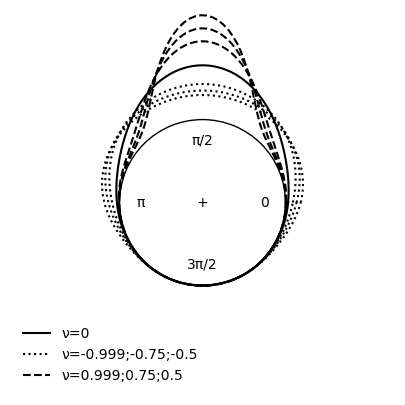

In [13]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(polar=True)

ax.plot(x, vonmisesext.pdf(x, kappa=3, nu=1e-9, loc=np.pi/2) + 1, linestyle='-', color='black', label='ν=0')

ax.plot(x, vonmisesext.pdf(x, kappa=3, nu=-0.999, loc=np.pi/2) + 1, linestyle=':', color='black', label='ν=-0.999;-0.75;-0.5')
ax.plot(x, vonmisesext.pdf(x, kappa=3, nu=-0.75, loc=np.pi/2) + 1, linestyle=':', color='black')
ax.plot(x, vonmisesext.pdf(x, kappa=3, nu=-0.5, loc=np.pi/2) + 1, linestyle=':', color='black')

ax.plot(x, vonmisesext.pdf(x, kappa=3, nu=0.999, loc=np.pi/2) + 1, linestyle='--', color='black', label='ν=0.999;0.75;0.5')
ax.plot(x, vonmisesext.pdf(x, kappa=3, nu=0.75, loc=np.pi/2) + 1, linestyle='--', color='black')
ax.plot(x, vonmisesext.pdf(x, kappa=3, nu=0.5, loc=np.pi/2) + 1, linestyle='--', color='black')

rtick = [0, 1]
ax.spines["polar"].set_visible(False)
ax.set_rgrids(rtick, ["" for _ in range(len(rtick))], fontsize=16)
gridlines = ax.yaxis.get_gridlines()
gridlines[-1].set_color("k")
gridlines[-1].set_linewidth(1)

# position_major = np.arange(0, 2 * np.pi, 2 * np.pi / 4)
position_major = []
ax.xaxis.set_major_locator(ticker.FixedLocator(position_major))

ax.text(x=0, y=0, s='+', ha='center', va="center", color="black",)
labels = ['0', 'π/2', 'π', '3π/2']
for i, angle in enumerate([0, np.pi/2, np.pi, 3 * np.pi / 2]):
    ax.text(x=angle, y=0.75, s=labels[i], ha='center', va="center", color="black")

ax.legend(frameon=False)

To be continue...

In [14]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p pycircstat2

Last updated: 2023-01-19 20:47:02CET

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

pycircstat2: 0.1.0

numpy     : 1.23.5
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:43:44) [Clang 13.0.1 ]
matplotlib: 3.5.3
polars    : 0.13.13

Watermark: 2.3.1

